# MNIST Prediction with Artificial Neural Network

- MNIST dataset: is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
- Goal: build a simple artificial neural network to predict the digit in the images.
- Reference: [Oddly Satisfying Deep Learning](https://pythonandml.github.io/dlbook/content/convolutional_neural_networks/cnn_over_mlp.html)

#### Import libraries

In [245]:
# for linear algebra
import numpy as np

# for plotting data, loss, accuracy
import matplotlib.pyplot as plt

# for convolutional neural network
from scipy import signal

# loading mnist dataset from keras
from keras import datasets

# show progress bar
from tqdm import tqdm

# for type hinting
from typing import Optional

## 1. Utility Functions

1. **plot_data**: plot the random 8 images from the dataset.
2. **Activation Functions**: Linear, reLU, Sigmoid, Tanh, Softmax.
3. **Weight Initialization**: Zeros, Ones, Random, Random Uniform.
4. **Optimization Functions**: Gradient Descent, Stochastic Gradient Descent, RMSprop, Adam.

In [246]:
class BaseLayer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        :param X: input data
        """
        # TODO: return output

        pass

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        """
        :param dZ: gradient of loss with respect to output
        :param lr: learning rate
        """
        # TODO: update parameters and return input gradient
        pass

### 1.1. Plotting Functions

In [247]:
def plot_data(
    X: np.ndarray, y: np.ndarray, y_proba: Optional[np.ndarray] = None
) -> None:
    nrows, ncols = 2, 4
    _, axes = plt.subplots(nrows, ncols, figsize=(8, 4))

    len_x = X.shape[0]
    for idx in range(nrows * ncols):
        ax = axes[idx // ncols, idx % ncols]

        img_idx = np.random.randint(0, len_x)

        ax.imshow(X[img_idx], cmap="gray")
        ax.set(xticks=[], yticks=[])

        true_label = f"True: {y[img_idx]}"
        color = "black"

        if y_proba is not None:
            pred_label = f"Pred: {y_proba[img_idx]}"
            color = "green" if y[img_idx] == y_proba[img_idx] else "red"

        img_title = true_label if y_proba is None else f"{true_label}\n{pred_label}"
        ax.set_xlabel(img_title, color=color)

    plt.tight_layout()
    plt.show()

### 1.2. Activation Functions class

In [248]:
class Activation(BaseLayer):
    def __init__(self, act: str = "relu") -> None:
        self.act = act

    def linear(self, x: np.ndarray) -> np.ndarray:
        return x

    def d_linear(self, x: np.ndarray) -> np.ndarray:
        return np.ones(x.shape)

    def reLU(self, x: np.ndarray) -> np.ndarray:
        return x * (x > 0)

    def d_reLU(self, x: np.ndarray) -> np.ndarray:
        return (x > 0) * np.ones(x.shape)

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x: np.ndarray) -> np.ndarray:
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x: np.ndarray) -> np.ndarray:
        return np.tanh(x)

    def d_tanh(self, x: np.ndarray) -> np.ndarray:
        return 1 - self.tanh(x) ** 2

    def get_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act == "linear":
            return self.linear(X)
        elif self.act == "sigmoid":
            return self.sigmoid(X)
        elif self.act == "tanh":
            return self.tanh(X)
        elif self.act == "reLU":
            return self.reLU(X)
        else:
            raise ValueError("Activation function not recognized")

    def get_d_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act == "linear":
            return self.d_linear(X)
        elif self.act == "sigmoid":
            return self.d_sigmoid(X)
        elif self.act == "tanh":
            return self.d_tanh(X)
        elif self.act == "reLU":
            return self.d_reLU(X)
        else:
            raise ValueError("Activation function not recognized")

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        :param X: input data
        """
        self.X = X
        return self.get_activation(X)

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        """
        :param dZ: gradient of loss with respect to output
        :param lr: learning rate
        """
        return np.multiply(dZ, self.get_d_activation(self.X))

### 1.3. Weight Initialization class

- Zeros initialization: $w = np.zeros(shape)$
- Ones initialization: $w = np.ones(shape)$
- Random initialization: $w = np.random.randn(shape)$
- Random uniform initialization: $w = np.random.uniform(size=shape)$

In [249]:
class WeightInitializer:
    def __init__(self, shape, init: str = "random", seed: int = 69) -> None:
        """
        :param shape: shape of the weight matrix
        :param init: type of initialization (available initializations: zeros, ones, random, random_uniform)
        :param seed: seed for random initialization
        """
        self.shape = shape
        self.init = init
        self.seed = seed

    def zeros(self) -> np.ndarray:
        return np.zeros(self.shape)

    def ones(self) -> np.ndarray:
        return np.ones(self.shape)

    def random(self) -> np.ndarray:
        np.random.seed(self.seed)
        return np.random.randn(*self.shape)

    def random_uniform(self) -> np.ndarray:
        np.random.seed(self.seed)
        return np.random.uniform(size=self.shape)

    def get_initializer(self) -> np.ndarray:
        if self.init == "zeros":
            return self.zeros()
        elif self.init == "ones":
            return self.ones()
        elif self.init == "random":
            return self.random()
        elif self.init == "random_uniform":
            return self.random_uniform()
        else:
            raise ValueError(
                "Valid initializations are: zeros, ones, random, random_uniform"
            )

### 1.4.  Optimizers class

- Gradient Descent Optimizer: $w = w - \alpha \nabla_w L(w)$
- Stochastic Gradient Descent Optimizer: $w = w - \alpha \nabla_w L(w)$
- RMSprop Optimizer: $v = \beta v + (1 - \beta) \nabla_w L(w) \odot \nabla_w L(w)$ and $w = w - \alpha \frac{\nabla_w L(w)}{\sqrt{v + \epsilon}}$
- Adam Optimizer: $m = \beta_1 m + (1 - \beta_1) \nabla_w L(w)$, $v = \beta_2 v + (1 - \beta_2) \nabla_w L(w) \odot \nabla_w L(w)$, $m_{\text{corrected}} = \frac{m}{1 - \beta_1^t}$, $v_{\text{corrected}} = \frac{v}{1 - \beta_2^t}$, and $w = w - \alpha \frac{m_{\text{corrected}}}{\sqrt{v_{\text{corrected}} + \epsilon}}$

> Note: Actually, i only use the Gradient Descent Optimizer in this notebook.

In [250]:
class Optimizer:
    def __init__(
        self,
        op_type: str = "GD",
        shape_W: tuple[int, int] = None,
        shape_b: tuple[int, int] = None,
        m1: float = 0.9,
        m2: float = 0.999,
        epsilon: int = 1e-8,
    ) -> None:
        """
        :param op_type: type of optimizer (available optimizers: GD, SGD, RMSProp, Adam)
        :param shape_W: shape of the weight matrix
        :param shape_b: shape of the bias matrix
        :param m1: hyperparameter >= 0 that accelerates gradient descent in the relevant direction and dampens oscillations. Used in RMSprop
        :param m2: hyperparameter for adam only
        :param epsilon: parameter used in adam and RMSprop to prevent division by zero error
        """
        if op_type is None:
            self.op_type = "GD"
        else:
            self.op_type = op_type

        self.m1 = m1
        self.m2 = m2
        self.epsilon = epsilon

        self.vdW = np.zeros(shape_W)
        self.vdb = np.zeros(shape_b)

        self.SdW = np.zeros(shape_W)
        self.Sdb = np.zeros(shape_b)

    def GD(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        return dW, db

    def SGD(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        self.vdW = self.momentum1 * self.vdW + (1 - self.momentum1) * dW
        self.vdb = self.momentum1 * self.vdb + (1 - self.momentum1) * db

        return self.vdW, self.vdb

    def RMSProp(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        self.SdW = self.momentum2 * self.SdW + (1 - self.momentum2) * (dW**2)
        self.Sdb = self.momentum2 * self.Sdb + (1 - self.momentum2) * (db**2)

        den_W = np.sqrt(self.SdW) + self.epsilon
        den_b = np.sqrt(self.Sdb) + self.epsilon

        return dW / den_W, db / den_b

    def Adam(self, dW: np.ndarray, db: np.ndarray, k: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        # momentum
        self.vdW = self.momentum1 * self.vdW + (1 - self.momentum1) * dW
        self.vdb = self.momentum1 * self.vdb + (1 - self.momentum1) * db

        # rmsprop
        self.SdW = self.momentum2 * self.SdW + (1 - self.momentum2) * (dW**2)
        self.Sdb = self.momentum2 * self.Sdb + (1 - self.momentum2) * (db**2)

        # correction
        if k > 1:
            vdW_h = self.vdW / (1 - (self.momentum1**k))
            vdb_h = self.vdb / (1 - (self.momentum1**k))
            SdW_h = self.SdW / (1 - (self.momentum2**k))
            Sdb_h = self.Sdb / (1 - (self.momentum2**k))
        else:
            vdW_h = self.vdW
            vdb_h = self.vdb
            SdW_h = self.SdW
            Sdb_h = self.Sdb

        den_W = np.sqrt(SdW_h) + self.epsilon
        den_b = np.sqrt(Sdb_h) + self.epsilon

        return vdW_h / den_W, vdb_h / den_b

    def get_optimizer(self, dW: np.ndarray, db: np.ndarray, k: int) -> tuple:
        if self.op_type == "GD":
            return self.GD(dW, db, k)
        elif self.op_type == "SGD":
            return self.SGD(dW, db, k)
        elif self.op_type == "RMSProp":
            return self.RMSProp(dW, db, k)
        elif self.op_type == "Adam":
            return self.Adam(dW, db, k)
        else:
            raise ValueError("Valid optiomizers are GD, SGD, RMSProp, Adam")

### 1.5. Loss Functions class

In [251]:
class Loss:
    def __init__(
        self, loss: str = "mse", y_true: np.ndarray = None, y_pred: np.ndarray = None
    ) -> None:
        """
        :param loss: str, loss function (Available: mse, bce)
        :param y_true: np.ndarray, true values
        :param y_pred: np.ndarray, predicted values
        """
        self.loss = loss
        self.y_true = y_true
        self.y_pred = y_pred

    # Mean Squared Error
    def mse(self) -> float:
        return np.mean(np.power(self.y_true - self.y_pred, 2))

    def d_mse(self) -> float:
        return 2 * (self.y_pred - self.y_true) / np.size(self.y_true)

    # Binary Cross Entropy
    def bce(self) -> float:
        return np.mean(
            -self.y_true * np.log(self.y_pred)
            - (1 - self.y_true) * np.log(1 - self.y_pred)
        )

    def d_bce(self) -> float:
        return (
            (1 - self.y_true) / (1 - self.y_pred) - self.y_true / self.y_pred
        ) / np.size(self.y_true)

    def get_loss(self) -> float:
        if self.loss == "mse":
            return self.mse()
        if self.loss == "bce":
            return self.bce()

    def get_d_loss(self) -> float:
        if self.loss == "mse":
            return self.d_mse()
        if self.loss == "bce":
            return self.d_bce()

## 2. Load Data

- Load the MNIST dataset from the `keras.datasets.mnist` module.
- Split the dataset into training and testing sets.

In [252]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

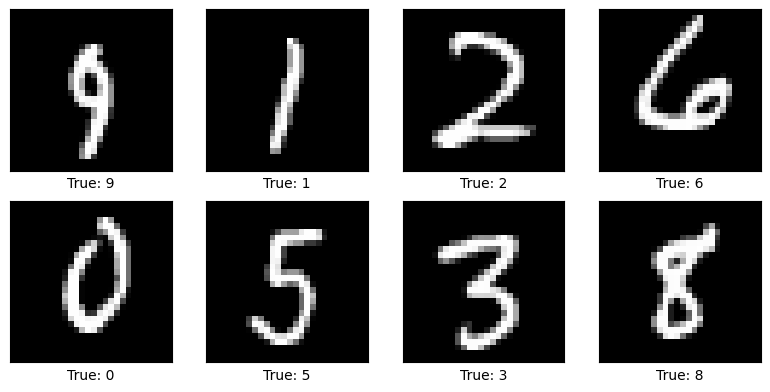

In [253]:
plot_data(X_train, y_train)

## 3. Preprocess Data

In [254]:
# Convert to float32 and scale to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [255]:
# Add channel dimension
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [256]:
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [257]:
# Convert class vectors to one-hot encoded
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [258]:
print("y_train shape:", y_train.shape)
print(y_train.shape[0], "train samples")
print(y_test.shape[0], "test samples")

y_train shape: (60000, 10)
60000 train samples
10000 test samples


## 4. Artificial Neural Network

### 4.1. With Convolutional Neural Network

#### 4.1.1. Convolutional Layer class

In [331]:
class Conv2D(BaseLayer):
    def __init__(
        self, inp_shape: tuple, kernel_size: int = 3, p: int = 0, s: int = 1
    ) -> None:
        """
        :param inp_shape: shape of the input data
        :param kernel_size: size of the kernel
        :param p: padding
        :param s: stride
        """
        self.height, self.width, self.depth = inp_shape
        self.p = p
        self.s = s
        self.height += 2 * self.p
        self.width += 2 * self.p

        self.kernel_size = kernel_size
        self.kernel = WeightInitializer(
            (
                self.depth,
                kernel_size,
                kernel_size,
            ),
            init="random",
        ).get_initializer()

        self.output_shape = (
            ((self.height - kernel_size) // self.s) + 1,
            ((self.width - kernel_size) // self.s) + 1,
            self.depth,
        )
        self.output = np.zeros(self.output_shape)

    def getROI(self, inp: np.ndarray):
        for row in range(self.output_shape[0]):
            for col in range(self.output_shape[1]):
                roi = inp[
                    row * self.s : row * self.s + self.kernel_size,
                    col * self.s : col * self.s + self.kernel_size,
                    :,
                ]
                yield row, col, roi

    def forward(self, X: np.ndarray) -> np.ndarray:
        X = np.pad(X, ((self.p, self.p), (self.p, self.p), (0, 0)), mode="constant")
        for layer in range(self.depth):
            for row, col, roi in self.getROI(X):
                self.output[row, col, layer] = np.sum(roi * self.kernel[layer])

        return self.output

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        dX = np.zeros((self.height, self.width, self.depth))
        dW = np.zeros(self.kernel.shape)

        dZ = np.pad(dZ, ((self.p, self.p), (self.p, self.p), (0, 0)), mode="constant")
        for layer in range(self.depth):
            for row, col, roi in self.getROI(dZ):
                dX[
                    row * self.s : row * self.s + self.kernel_size,
                    col * self.s : col * self.s + self.kernel_size,
                    :,
                ] += (
                    self.kernel[layer] * roi
                )
                dW[layer] += roi * self.kernel[layer]

        self.kernel -= lr * dW
        return dX

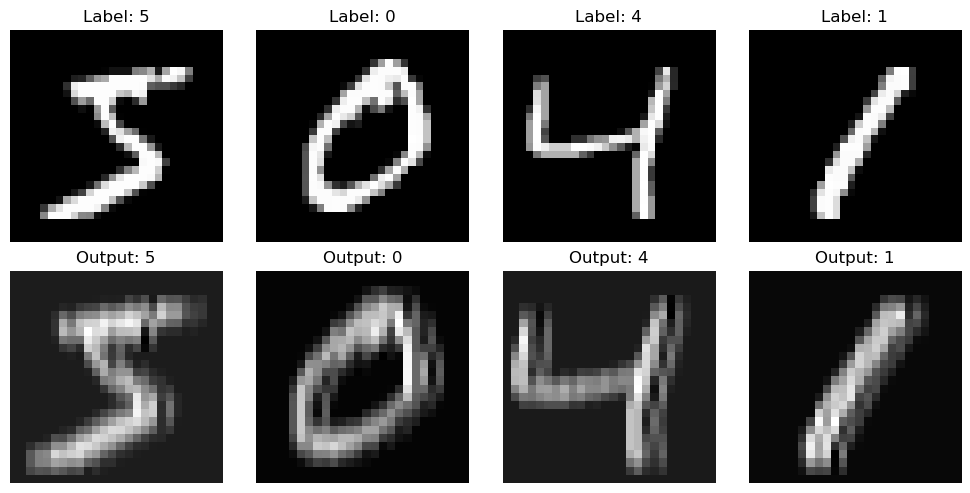

In [361]:
raw_X = X_train[0:4]
raw_y = y_train[0:4]

fig, ax = plt.subplots(2, 4, figsize=(10, 5))

for i in range(4):
    ax[0, i].imshow(raw_X[i, :, :, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[0, i].set_title(f"Label: {np.argmax(raw_y[i])}")

    conv = Conv2D(raw_X[i].shape, kernel_size=3)
    output = conv.forward(raw_X[i])
    ax[1, i].imshow(output[:, :, 0], cmap="gray")
    ax[1, i].axis("off")
    ax[1, i].set_title(f"Output: {np.argmax(raw_y[i])}")

plt.tight_layout()
plt.show()

#### 4.1.2. Pooling Layer class

In [390]:
# max pooling


class Pooling2D(BaseLayer):
    def __init__(self, inp_shape: tuple, pool_size: int = 2) -> None:
        """
        :param inp_shape: shape of the input data
        :param pool_size: size of the pooling kernel
        :param s: stride
        """
        self.height, self.width, self.depth = inp_shape
        self.pool_size = pool_size
        self.output_shape = (
            self.height // pool_size,
            self.width // pool_size,
            self.depth,
        )
        self.output = np.zeros(self.output_shape)

    def getROI(self, inp: np.ndarray):
        for row in range(self.output_shape[0]):
            for col in range(self.output_shape[1]):
                roi = inp[
                    row * self.pool_size : row * self.pool_size + self.pool_size,
                    col * self.pool_size : col * self.pool_size + self.pool_size,
                    :,
                ]
                yield row, col, roi

    def forward(self, X: np.ndarray) -> np.ndarray:
        for layer in range(self.depth):
            for row, col, roi in self.getROI(X):
                self.output[row, col, layer] = np.max(roi)

        return self.output

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        dX = np.zeros((self.height, self.width, self.depth))

        for layer in range(self.depth):
            for row, col, roi in self.getROI(dZ):
                mask = roi == np.max(roi)
                dX[
                    row * self.pool_size : row * self.pool_size + self.pool_size,
                    col * self.pool_size : col * self.pool_size + self.pool_size,
                    :,
                ] += (
                    mask * dZ[row, col, layer]
                )

        return dX

#### 4.1.3. Flatten Layer class

In [395]:
class Flatten(BaseLayer):
    def __init__(self, inp_shape: tuple) -> None:
        """
        :param inp_shape: shape of the input data
        """
        self.inp_shape = inp_shape
        self.output_shape = np.prod(self.inp_shape)
        self.output = np.zeros(self.output_shape)

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        self.output = X.flatten()
        return self.output

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        return dZ.reshape(self.inp_shape)

#### 4.1.4. Dense Layer class

In [407]:
class Dense(BaseLayer):
    def __init__(self, input_size: int, output_size: int) -> None:
        """
        :param input_size: size of input vector
        :param output_size: size of output vector
        """
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input: np.ndarray) -> np.ndarray:
        """
        :param input: input vector
        """
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        """
        :param dZ: gradient of loss with respect to output
        :param lr: learning rate
        """
        dW = np.dot(dZ, self.input.T)
        dX = np.dot(self.weights.T, dZ)
        self.weights -= lr * dW
        self.bias -= lr * dZ
        return dX

#### 4.1.5. Neural Network class

In [433]:
class CNN:
    def __init__(self, lr: float = 0.001) -> None:
        self.lr = lr
        self.layers = []

    def add(self, layer: BaseLayer) -> None:
        self.layers.append(layer)

    def fit(
        self, X: np.ndarray, y: np.ndarray, epochs: int, verbose: bool = False
    ) -> None:
        pass

In [474]:
X = X_train[0:4]
y = y_train[0:4]

lr = 0.001

for i in range(4):
    conv = Conv2D(X[i].shape, kernel_size=3)
    act1 = Activation(act="reLU")
    pool = Pooling2D(a1.shape, pool_size=2)
    flat = Flatten(p1.shape)
    dense = Dense(f1.shape[0], 10)

    # forward pass
    z1 = conv.forward(X[i])
    a1 = act1.forward(z1)
    p1 = pool.forward(a1)
    f1 = flat.forward(p1)
    z2 = dense.forward(f1)

    # backward pass
    dZ2 = Loss(loss="mse", y_true=y[i], y_pred=z2).get_d_loss()
    dF1 = dense.backpropagation(dZ2, lr)
    dP1 = flat.backpropagation(dF1, lr)
    dA1 = pool.backpropagation(dP1, lr)
    dZ1 = act1.backpropagation(dA1, lr)
    dX = conv.backpropagation(dZ1, lr)

AttributeError: 'NoneType' object has no attribute 'reshape'

### 4.2 With Keras

In [260]:
from keras import models, layers

In [261]:
inp_shape = X_train.shape[1:]

In [262]:
model = models.Sequential(
    [
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [263]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [264]:
batch_size = 128
epochs = 5

history = model.fit(
    X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1
)

Epoch 1/5
422/422 [==============================] - 1s 2ms/step - loss: 0.4397 - accuracy: 0.8738 - val_loss: 0.1020 - val_accuracy: 0.9707
Epoch 2/5
422/422 [==============================] - 1s 1ms/step - loss: 0.0936 - accuracy: 0.9721 - val_loss: 0.0766 - val_accuracy: 0.9788
Epoch 3/5
422/422 [==============================] - 1s 1ms/step - loss: 0.0550 - accuracy: 0.9827 - val_loss: 0.0803 - val_accuracy: 0.9785
Epoch 4/5
422/422 [==============================] - 1s 1ms/step - loss: 0.0320 - accuracy: 0.9903 - val_loss: 0.0755 - val_accuracy: 0.9795
Epoch 5/5
422/422 [==============================] - 1s 2ms/step - loss: 0.0244 - accuracy: 0.9923 - val_loss: 0.0890 - val_accuracy: 0.9757


#### 4.2.1. Model results

In [265]:
history_dict = history.history

In [266]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [267]:
train_loss, val_loss = history_dict["loss"], history_dict["val_loss"]
train_acc, val_acc = history_dict["accuracy"], history_dict["val_accuracy"]

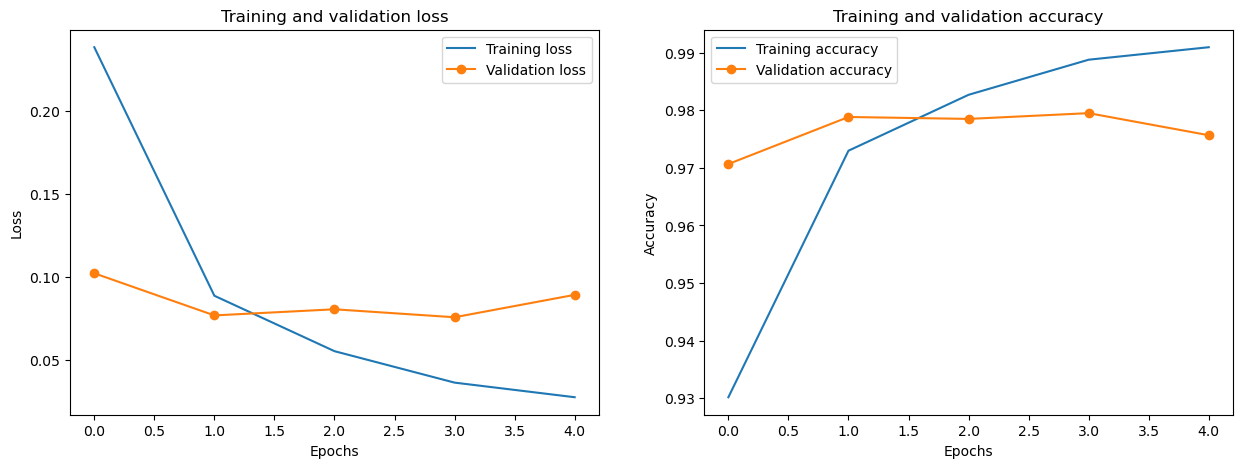

In [268]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
epochs_run = [i for i in range(epochs)]

ax1.plot(epochs_run, train_loss, label="Training loss")
ax1.plot(epochs_run, val_loss, label="Validation loss", marker="o")

ax1.set_title("Training and validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(epochs_run, train_acc, label="Training accuracy")
ax2.plot(epochs_run, val_acc, label="Validation accuracy", marker="o")

ax2.set_title("Training and validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

#### 4.2.1. Model prediction

In [269]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0761643499135971
Test accuracy: 0.9771000146865845


In [270]:
y_pred = model.predict(X_test)

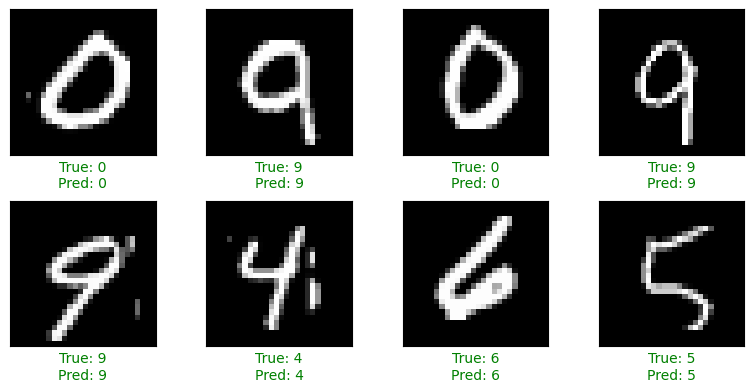

In [275]:
plot_data(X_test, np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))